## PCB Images Training & Testing

### 1. Load the relevant libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
print(tf.__version__)

### 2. Load training set

In [11]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/data/PCB/Training_Dataset',
    validation_split = 0.2,
    subset = "training",
    batch_size = 32,
    seed=123,
    image_size=(110, 42),
    shuffle=True)

Found 12000 files belonging to 8 classes.
Using 9600 files for training.


### 3. Perform sanity checks

In [12]:
class_names = training_set.class_names
print(class_names)
data_iterator = training_set.as_numpy_iterator()
batch = data_iterator.next()
print(batch[0].shape)
batch[1]

['0', '1', '2', '3', '4', '5', '6', '7']
(32, 110, 42, 3)


array([0, 0, 1, 0, 0, 0, 0, 3, 1, 1, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3,
       0, 4, 3, 0, 1, 0, 1, 0, 0, 4])

### 4. Plot some images

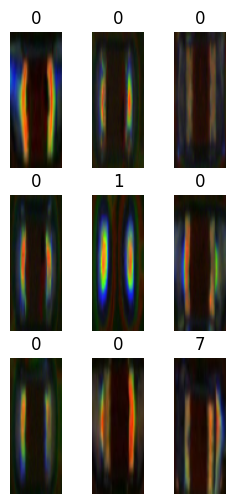

In [16]:
plt.figure(figsize=(3, 6))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### 5. Standardize data

In [17]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = training_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8580699


In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_set = training_set.cache().prefetch(buffer_size=AUTOTUNE)

### 6. DEFINE the model

In [19]:
num_classes = 8
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [20]:
model.compile(
  optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ['accuracy'])

In [21]:
val_set = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/data/PCB/Training_Dataset',
    validation_split = 0.2,
    subset = "validation",
    batch_size = 32,
    seed=123,
    image_size=(110, 42),
    shuffle=True)

Found 12000 files belonging to 8 classes.
Using 2400 files for validation.


### 8. Fit the model

In [22]:
history = model.fit(
  training_set,
  validation_data = val_set,
  epochs=3
)

Epoch 1/3
300/300 [==============================] - 38s 125ms/step - loss: 0.4831 - accuracy: 0.8518 - val_loss: 0.2159 - val_accuracy: 0.9250
Epoch 2/3
300/300 [==============================] - 35s 118ms/step - loss: 0.1966 - accuracy: 0.9379 - val_loss: 0.1540 - val_accuracy: 0.9525
Epoch 3/3
300/300 [==============================] - 36s 119ms/step - loss: 0.1439 - accuracy: 0.9530 - val_loss: 0.1315 - val_accuracy: 0.9608


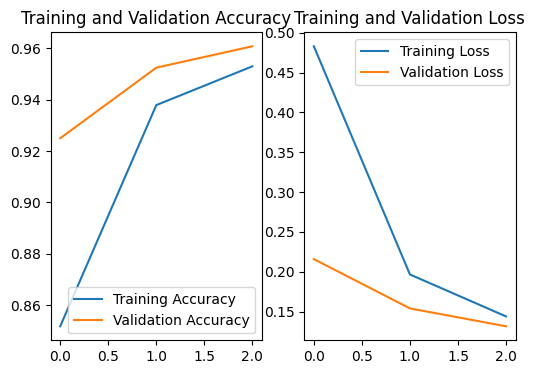

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(3)

plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 9. Predict from Evaluation Data

In [28]:
import cv2
import matplotlib.image as pmg

In [ ]:
test_path = "D:/data/PCB/Evaluation_Dataset"
image_names = []
class_name_pred = []
pred_prob = []
for filename in os.listdir(test_path):
    img = pmg.imread(os.path.join(test_path, filename))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) #Create batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    image_names.append(filename)
    #print("This image belongs to class {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))
    class_name_pred.append(class_names[np.argmax(score)])
    pred_prob.append(100*np.max(score))

### 10. Write output to Text file

In [42]:
with open('class_output.txt', 'w') as f:    
    f.write("Image Name  ---- Class ----- Prob")
    f.write('\n')
    for val in range(len(class_name_pred)):
        f.write(str(image_names[val]) + "-----" + str(class_name_pred[val]) + "-----" + str(pred_prob[val]))
        f.write('\n')
    

In [ ]:
test_path_image1 = "D:/data/PCB/Evaluation_Dataset/20200314194603_200366067100405_O2R58_1_view50.png"
img = pmg.imread(test_path_image1)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #Create batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print("This image belongs to class {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))